# 第三章 基于回归残差的价值发现模型

## 3.1 理论升华：从因子组合到模型驱动

## 3.2 模型构建与因子定义
### 构建市场定价基准：横截面回归
### 计算个股的理论估值
### 度量估值偏离：定义估值残差因子

## 3.3 估值残差因子的有效性检验
### 分布特征分析
### 收益率分组回归分析

## 3.4 策略实证：分组回测分析
### 绩效分组结果
### 多头策略与空头策略的分析
### 多空组合表现与Alpha强度

## 3.5 最终策略对比与评估
### 与月度再平衡策略的比较
### 绩效指标对照与评估结论

## 3.6 本章小结


In [30]:
#绘图字体和配色
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 16

class AcademicColors:
    """
    学术严谨风格配色方案
    基于Nature、Science等顶级科学期刊的设计理念
    """

    def __init__(self):
        # 主色板
        self.primary = '#333333'
        self.secondary = '#000000'
        self.background = '#F0F0F0'
        self.gridline = '#D9D9D9'

        # 分类色板（图表专用）
        self.categorical = [
            '#FF8C00',  # 明亮橙色 (保留)
            '#6A7FDB',  # 明亮靛蓝 (保留)
            '#2E8B7A',  # 深青 (保留)
            '#A0522D',  # 深红棕色 (替换金色)
            '#DA70D6',  # 明亮兰花紫 (保留)
            '#87CEEB',  # 天蓝色 (保留)
        ]

        # 发散色板
        self.diverging = [
            '#053061',  # 深蓝
            '#67A9CF',  # 浅蓝
            '#F7F7F7',  # 中性灰
            '#EF8A62',  # 浅红
            '#B2182B'   # 深红
        ]

        # 创建颜色映射
        self.categorical_cmap = ListedColormap(self.categorical)
        self.diverging_cmap = ListedColormap(self.diverging)

    def set_style(self):
        """设置matplotlib和seaborn的学术风格"""
        # 设置seaborn样式
        sns.set_style("whitegrid", {
            "axes.linewidth": 0.8,
            "grid.linewidth": 0.5,
            "grid.color": self.gridline,
            "axes.edgecolor": self.secondary,
            "axes.spines.left": True,
            "axes.spines.bottom": True,
            "axes.spines.top": False,
            "axes.spines.right": False,
        })

        # 设置matplotlib参数
        plt.rcParams.update({
            'font.size': 10,
            'axes.titlesize': 12,
            'axes.labelsize': 10,
            'xtick.labelsize': 9,
            'ytick.labelsize': 9,
            'legend.fontsize': 9,
            'figure.titlesize': 14,
            'axes.titlecolor': self.secondary,
            'axes.labelcolor': self.primary,
            'text.color': self.primary,
            'axes.edgecolor': self.secondary,
            'xtick.color': self.primary,
            'ytick.color': self.primary,
            'grid.alpha': 0.6,
            'axes.axisbelow': True
        })

        # 设置默认调色板
        sns.set_palette(self.categorical)

    def get_colors(self, n=None, palette_type='categorical'):
        """
        获取指定数量的颜色

        Parameters:
        -----------
        n : int, optional
            需要的颜色数量，如果为None则返回完整调色板
        palette_type : str
            调色板类型，'categorical' 或 'diverging'

        Returns:
        --------
        list : 颜色列表
        """
        if palette_type == 'categorical':
            colors = self.categorical
        elif palette_type == 'diverging':
            colors = self.diverging
        else:
            raise ValueError("palette_type must be 'categorical' or 'diverging'")

        if n is None:
            return colors
        elif n <= len(colors):
            return colors[:n]
        else:
            # 如果需要的颜色数量超过调色板，则循环使用
            return (colors * ((n // len(colors)) + 1))[:n]

    def _draw_palette_on_ax(self, colors, ax, title):
        """
        在指定的轴上绘制调色板
        这是palplot的替代方案，因为palplot不支持ax参数
        """
        n_colors = len(colors)
        ax.imshow(np.arange(n_colors).reshape(1, n_colors),
                  cmap=ListedColormap(colors),
                  interpolation="nearest",
                  aspect="auto")

        # 设置刻度和标签
        ax.set_xticks(np.arange(n_colors))
        ax.set_xticklabels([f'{i+1}' for i in range(n_colors)])
        ax.set_yticks([])
        ax.set_title(title, fontsize=12, color=self.secondary, pad=15)

        # 添加颜色值标签
        for i, color in enumerate(colors):
            ax.text(i, 0, color.upper(),
                   ha='center', va='center',
                   fontsize=8, color='white' if self._is_dark_color(color) else 'black',
                   weight='bold')

    def _is_dark_color(self, hex_color):
        """判断颜色是否为深色"""
        # 移除#号并转换为RGB
        hex_color = hex_color.lstrip('#')
        rgb = tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))
        # 计算亮度
        brightness = (rgb[0] * 299 + rgb[1] * 587 + rgb[2] * 114) / 1000
        return brightness < 128

    def show_palette(self, palette_type='all'):
        """
        展示调色板

        Parameters:
        -----------
        palette_type : str
            'categorical', 'diverging', 或 'all'
        """
        if palette_type == 'all':
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
            self._draw_palette_on_ax(self.categorical, ax1, '分类色板（Categorical Palette）')
            self._draw_palette_on_ax(self.diverging, ax2, '发散色板（Diverging Palette）')
        elif palette_type == 'categorical':
            fig, ax = plt.subplots(1, 1, figsize=(10, 3))
            self._draw_palette_on_ax(self.categorical, ax, '分类色板（Categorical Palette）')
        elif palette_type == 'diverging':
            fig, ax = plt.subplots(1, 1, figsize=(10, 3))
            self._draw_palette_on_ax(self.diverging, ax, '发散色板（Diverging Palette）')
        else:
            raise ValueError("palette_type must be 'categorical', 'diverging', or 'all'")

        plt.tight_layout()
        plt.show()

    def show_simple_palette(self, palette_type='all'):
        """
        使用seaborn的palplot展示调色板（简单版本，不支持自定义轴）
        """
        if palette_type in ['categorical', 'all']:
            print("分类色板（Categorical Palette）:")
            sns.palplot(self.categorical)
            plt.show()

        if palette_type in ['diverging', 'all']:
            print("发散色板（Diverging Palette）:")
            sns.palplot(self.diverging)
            plt.show()

    def demo_plots(self):
        """展示使用示例"""
        # 创建示例数据
        np.random.seed(42)
        categories = ['组别A', '组别B', '组别C', '组别D', '组别E']
        values = np.random.randint(10, 100, len(categories))

        # 创建子图
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
        fig.suptitle('学术严谨风格图表示例', fontsize=16, color=self.secondary, y=0.95)

        # 柱状图
        bars = ax1.bar(categories, values, color=self.get_colors(len(categories)))
        ax1.set_title('实验组数据对比', fontweight='bold')
        ax1.set_ylabel('测量值')
        ax1.grid(True, alpha=0.3)

        # 散点图
        x = np.random.normal(0, 1, 100)
        y = np.random.normal(0, 1, 100)
        groups = np.random.choice(categories[:3], 100)

        for i, group in enumerate(categories[:3]):
            mask = groups == group
            ax2.scatter(x[mask], y[mask],
                       color=self.categorical[i],
                       label=group, alpha=0.7, s=50)

        ax2.set_title('多组数据分布', fontweight='bold')
        ax2.set_xlabel('变量 X')
        ax2.set_ylabel('变量 Y')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

        # 热力图数据
        data = np.random.randn(5, 5)
        im = ax3.imshow(data, cmap=self.diverging_cmap, aspect='auto')
        ax3.set_title('相关性矩阵热力图', fontweight='bold')
        ax3.set_xticks(range(5))
        ax3.set_yticks(range(5))
        ax3.set_xticklabels([f'特征{i+1}' for i in range(5)])
        ax3.set_yticklabels([f'特征{i+1}' for i in range(5)])

        # 添加颜色条
        cbar = plt.colorbar(im, ax=ax3, shrink=0.8)
        cbar.set_label('相关系数')

        # 线图
        x_line = np.linspace(0, 10, 50)
        for i in range(3):
            y_line = np.sin(x_line + i) + np.random.normal(0, 0.1, 50)
            ax4.plot(x_line, y_line,
                    color=self.categorical[i],
                    label=f'条件{i+1}',
                    linewidth=2)

        ax4.set_title('时间序列对比', fontweight='bold')
        ax4.set_xlabel('时间')
        ax4.set_ylabel('响应值')
        ax4.legend()
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

# 创建全局颜色实例
academic_colors = AcademicColors()

# 便捷函数
def set_academic_style():
    """快速设置学术风格"""
    academic_colors.set_style()

def get_academic_colors(n=None, palette_type='categorical'):
    """快速获取学术配色"""
    return academic_colors.get_colors(n, palette_type)

def show_academic_palette(palette_type='all'):
    """快速展示调色板（修复版本）"""
    academic_colors.show_palette(palette_type)

def show_simple_palette(palette_type='all'):
    """使用seaborn原生palplot展示调色板"""
    academic_colors.show_simple_palette(palette_type)

# 使用示例
if __name__ == "__main__":
    print("学术严谨风格配色方案已加载！")
    print("\n使用方法：")
    print("1. set_academic_style() - 设置学术风格")
    print("2. get_academic_colors(n, 'categorical') - 获取分类颜色")
    print("3. get_academic_colors(n, 'diverging') - 获取发散颜色")
    print("4. show_academic_palette() - 展示所有调色板（修复版本）")
    print("5. show_simple_palette() - 展示调色板（简单版本）")
    print("6. academic_colors.demo_plots() - 查看使用示例")


学术严谨风格配色方案已加载！

使用方法：
1. set_academic_style() - 设置学术风格
2. get_academic_colors(n, 'categorical') - 获取分类颜色
3. get_academic_colors(n, 'diverging') - 获取发散颜色
4. show_academic_palette() - 展示所有调色板（修复版本）
5. show_simple_palette() - 展示调色板（简单版本）
6. academic_colors.demo_plots() - 查看使用示例


# 第三章：基于回归残差的价值发现模型

### 一、现有框架的理论局限性

在本书第一章，我们构建了 PB-ROE 策略的初始版本。该策略采用了如下两步筛选法：

1. **高质量股票池**：选取盈利能力强的公司（如 ROE 前 33%）。
2. **低估值股票池**：选取估值较低的公司（如 P/B 后 33%）。
3. 最终组合：取上述两个股票池的交集。

此策略虽直观有效，但忽略了 ROE 与 ln(P/B) 之间的**内在线性关系**。其将质量与价值作为**独立维度**进行考虑，从而导致一个核心问题——用一把“绝对估值标尺”来衡量不同盈利能力的公司，忽视了估值本质上的**相对性**。

#### 场景说明：公司A 与 公司B

| 公司 | ROE | P/B | 初始策略是否入选 | 原因说明 |
|------|-----|-----|------------------|----------|
| 公司A | 25% | 1.8 | ❌ | P/B 不够低 |
| 公司B | 10% | 0.9 | ❌ | ROE 不够高 |

尽管两家公司各具优势，却因无法满足“同时进入两个顶尖分位”而被策略遗漏。

---

### 二、改进理由与逻辑：从因子组合到模型驱动

为克服上述刚性缺陷，我们基于第一章理论模型，构建一个**由回归残差驱动**的价值发现机制：

#### 步骤一：构建市场定价基准（横截面回归）

对所有股票进行横截面回归：

$$
\ln(P/B)_i = \alpha + \beta \cdot ROE_i + \epsilon_i
$$

- 回归系数 \( \beta \)：市场对单位盈利能力的“估值溢价”，即当前 ROE 的定价水平。

#### 步骤二：计算个股理论估值

对每只股票，计算理论 ln(P/B)：

$$
\widehat{\ln(P/B)_i} = \hat{\alpha} + \hat{\beta} \cdot ROE_i
$$

#### 步骤三：计算估值残差 \( \epsilon_i \)

$$
\epsilon_i = \ln(P/B_i)_{\text{实际}} - \widehat{\ln(P/B_i)}
$$

- \( \epsilon_i < 0 \)：表示股票被“低估”，估值低于其盈利水平对应的理论值。
- 残差绝对值越大 → 低估程度越深。

---

### 案例重算（假设定价方程为：ln(P/B) = 0.1 + 5×ROE）

| 公司 | ROE | P/B | 实际 ln(P/B) | 理论 ln(P/B) | 残差 \( \epsilon_i \) |
|------|-----|-----|----------------|------------------|--------------------|
| A | 25% | 1.8 | ≈ 0.588 | 1.35 | -0.762 |
| B | 10% | 0.9 | ≈ -0.105 | 0.60 | -0.705 |

尽管 A 的 P/B 更高，但其残差更负，代表被**更严重低估**。

---

### 三、模型洞见与投资逻辑转变

从原策略的“绝对低 P/B”筛选逻辑转向：

> **买入估值残差 \( \epsilon_i \) 最低的股票组合**

此框架将质量（ROE）与价值（P/B）**融合于统一模型中**，不再是因子的线性叠加，而是基于“价值回归收敛”假设构建出：

- 更严谨的选股逻辑
- 更具金融解释力的残差驱动策略

为后续策略优化提供了强大基础。

---


In [1]:
# 从数据库导入数据dfpbroemonthly
import pandas as pd
from sqlalchemy import create_engine

# 根据你的实际数据库信息填写
username = "panjinhe"
password = "20020112p"
host = "localhost"
port = "5432"
database = "pbroe"

# 定义要查询的表和schema
table_name = 'pbroe_monthly'
schema_name = 'pbroe'

# 定义日期范围
start_date = '2010-04'
end_date = '2025-03'

# 构建连接字符串
connection_string = f"postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}"

# 创建引擎
engine = create_engine(connection_string)

# 构建带有日期范围筛选的SQL查询语句
# 这样可以在数据库层面直接过滤，效率更高
sql_query = f"""
SELECT * FROM {schema_name}.{table_name}
WHERE "Trdmnt" >= '{start_date}' AND "Trdmnt" <= '{end_date}'
"""
# 使用 pd.read_sql_query 执行带有条件的查询
dfpbroemonthly = pd.read_sql_query(sql_query, engine)

# print("\n数据加载成功！")
# # --- 3. 显示数据信息 ---
# print("\nDataFrame Info:")
# print(dfpbroemonthly.info())
# print("\nDataFrame Head (first 10 rows):")
# display(dfpbroemonthly.head(10))

In [20]:
# 选股：pbroe3.1
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pathlib import Path

# =================================================================== #
#                           【1. 配置区域】                           #
# =================================================================== #
# 此处假设 dfpbroemonthly 变量已在之前的单元格中成功创建

# --- 输出文件配置 ---
OUTPUT_DIR = Path(r'E:\PBROE\ch3')
OUTPUT_FILENAME = 'pbroe3.1.csv'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True) # 确保输出目录存在


# =================================================================== #
#                       【2. 数据清洗与预处理】                       #
# =================================================================== #
print("--- 步骤 1: 数据清洗与预处理 ---")

# 确保 dfpbroemonthly 存在
if 'dfpbroemonthly' not in locals():
    print("错误: 变量 'dfpbroemonthly' 未定义。请先运行数据加载的代码单元格。")
else:
    df = dfpbroemonthly.copy()

    # 1. 重命名PB列，方便后续使用
    df.rename(columns={'PBV1B': 'PB'}, inplace=True)

    # 2. 剔除ST,*ST股票 (假设 ifst=1 为ST)
    df = df[df['ifst'] != 1]

    # 4. 【回归模型特定清洗】剔除不符合回归条件的样本
    # PB必须大于0才能取对数；ROE不能过高以避免极端值影响
    df = df[(df['PB'] > 0) & (df['ROEttm'] <= 0.5) & (df['ROEttm'] >= -0.1)]

    # 5. 剔除关键指标为空的记录
    df.dropna(subset=['ROEttm', 'PB', 'indnme1'], inplace=True)

    # 6. 计算ln(PB)
    df['lnPB'] = np.log(df['PB'])

    print(f"数据清洗后，剩余 {len(df)} 条有效记录用于回归分析。")


    # =================================================================== #
    #              【3. 执行月度行业内回归与残差计算】                    #
    # =================================================================== #
    print("\n--- 步骤 2: 执行月度行业内回归与残差计算 ---")

    def calculate_residuals(group):
        """
        对给定的分组（某行业某月份），执行回归并计算标准化残差。
        """
        # 行业内样本数过少，无法进行有意义的回归
        if len(group) < 10:
            group['residual_zscore'] = np.nan
            return group

        try:
            # 准备回归的Y和X
            y = group['lnPB']
            X = sm.add_constant(group['ROEttm']) # 添加常数项

            # 执行OLS回归
            model = sm.OLS(y, X, missing='drop').fit()

            # 获取残差
            residuals = model.resid

            # 计算残差的均值和标准差
            resid_mean = residuals.mean()
            resid_std = residuals.std()

            # 标准化残差 (Z-score)
            if resid_std > 1e-6: # 避免除以零
                group['residual_zscore'] = (residuals - resid_mean) / resid_std
            else:
                group['residual_zscore'] = 0.0

        except Exception as e:
            # 如果回归出错，则将残差设为空值
            # print(f"回归失败于 Trdmnt={group['Trdmnt'].iloc[0]}, indnme1={group['indnme1'].iloc[0]}: {e}")
            group['residual_zscore'] = np.nan

        return group

    # 按月份和行业分组，应用回归函数
    regression_results = df.groupby(['Trdmnt', 'indnme1']).apply(calculate_residuals, include_groups=False)

    # 清除回归失败或无法计算残差的记录
    regression_results.dropna(subset=['residual_zscore'], inplace=True)

    print(f"回归与残差计算完成，共得到 {len(regression_results)} 条有效记录。")


    # =================================================================== #
    #                       【4. 格式化并保存结果】                       #
    # =================================================================== #
    print("\n--- 步骤 3: 格式化并保存最终数据文件 ---")

    if not regression_results.empty:
        # 重置索引，将Trdmnt和indnme1变回列
        final_data = regression_results.reset_index()

        # 创建“调入日期”列
        final_data['调入日期'] = pd.to_datetime(final_data['Trdmnt'] + '-01') + pd.DateOffset(months=1)

        # 选择最终需要的列
        output_columns = ['调入日期', 'stkcd', 'shortname', 'indnme1', 'ROEttm', 'PB', 'residual_zscore']
        final_portfolio_data = final_data[output_columns]

        # 保存到CSV文件
        output_path = OUTPUT_DIR / OUTPUT_FILENAME
        final_portfolio_data.to_csv(output_path, index=False, encoding='utf-8-sig', float_format='%.6f')

        print(f"\n策略数据已成功生成并保存为 '{output_path}'。")
        print("该文件包含了所有股票的标准化残差，可用于后续不同阈值的组合构建。")
        print("\n文件预览（按残差升序排列）：")
        try:
            display(final_portfolio_data.sort_values('residual_zscore').head())
        except NameError:
            print(final_portfolio_data.sort_values('residual_zscore').head())
    else:
        print("\n未能计算出任何有效残差，无法生成数据文件。")


--- 步骤 1: 数据清洗与预处理 ---
数据清洗后，剩余 521433 条有效记录用于回归分析。

--- 步骤 2: 执行月度行业内回归与残差计算 ---
回归与残差计算完成，共得到 499809 条有效记录。

--- 步骤 3: 格式化并保存最终数据文件 ---

策略数据已成功生成并保存为 'E:\PBROE\ch3\pbroe3.1.csv'。
该文件包含了所有股票的标准化残差，可用于后续不同阈值的组合构建。

文件预览（按残差升序排列）：


,调入日期,stkcd,shortname,indnme1,ROEttm,PB,residual_zscore
472393,2024-10-01,000413,东旭光电,计算机、通信和其他电子设备制造业,-0.071403,0.096286,-6.024607
468090,2024-09-01,000413,东旭光电,计算机、通信和其他电子设备制造业,-0.077396,0.096286,-5.483283
457662,2024-07-01,600277,亿利洁能,化学原料和化学制品制造业,-0.035919,0.071005,-5.005612
463827,2024-08-01,000413,东旭光电,计算机、通信和其他电子设备制造业,-0.077396,0.158742,-4.561665
481548,2024-12-01,689009,九号公司,计算机、通信和其他电子设备制造业,0.206565,0.520048,-4.234704


--- 步骤 1: 加载残差数据和收益率数据 ---
成功加载 499809 条残差数据。
成功加载 887384 条收益率数据。

--- 步骤 2: 合并数据，将 T 期的残差与 T+1 期的收益率对齐 ---
数据合并完成，共得到 499789 条有效的分析样本。

--- 步骤 3: 绘制残差分布直方图 ---
残差分布图已保存至: ch3_pics\residual_distribution_histogram.png


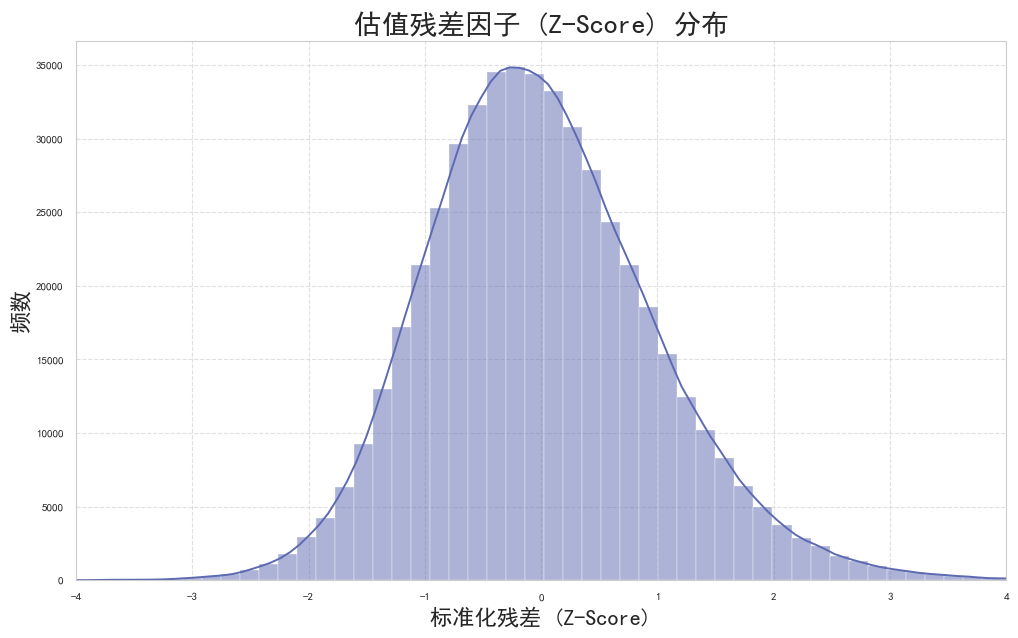


--- 步骤 4: 绘制残差分组与收益率关系图 ---
残差-收益率关系(箱线图)已保存至: ch3_pics\residual_return_boxplot.png


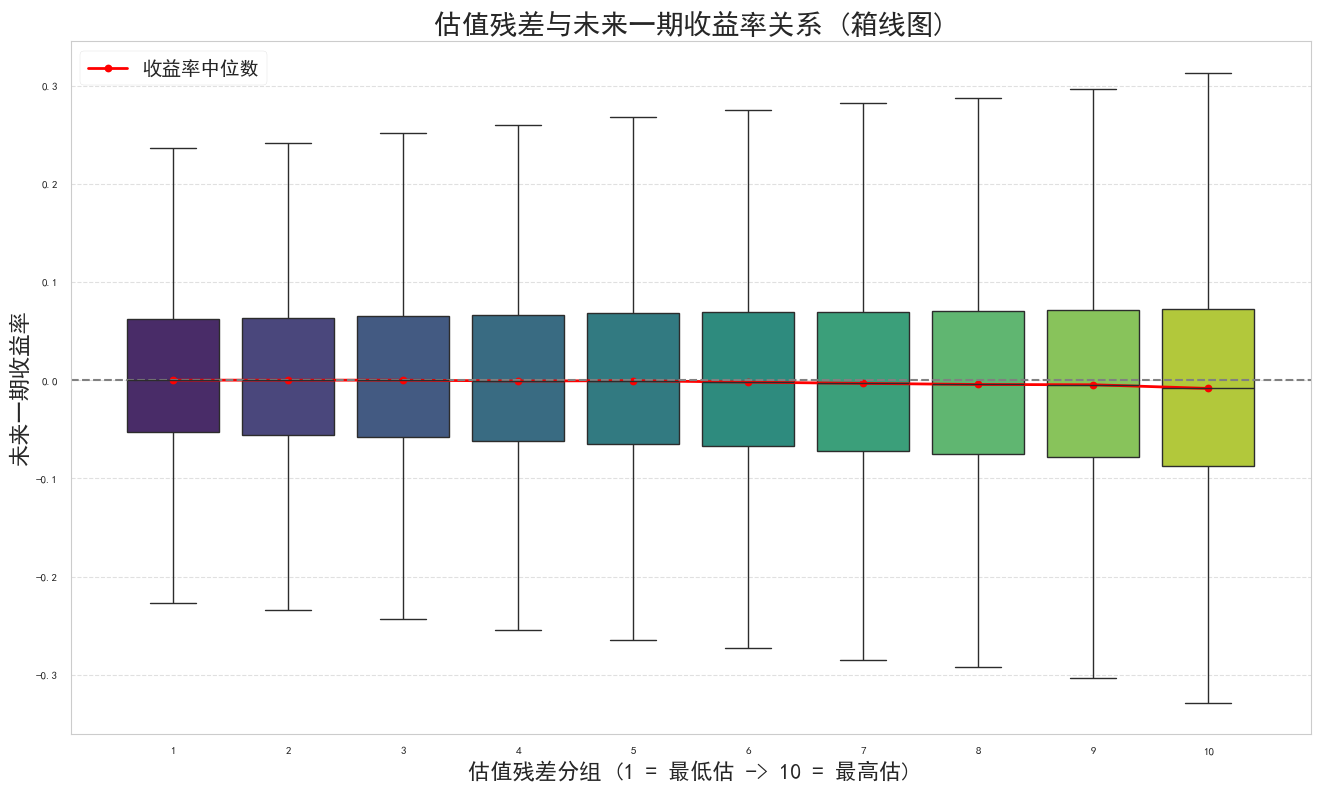


--- 步骤 5: 绘制残差分组与平均收益率关系柱状图 ---
残差-平均收益率关系(柱状图)已保存至: ch3_pics\residual_return_barplot.png


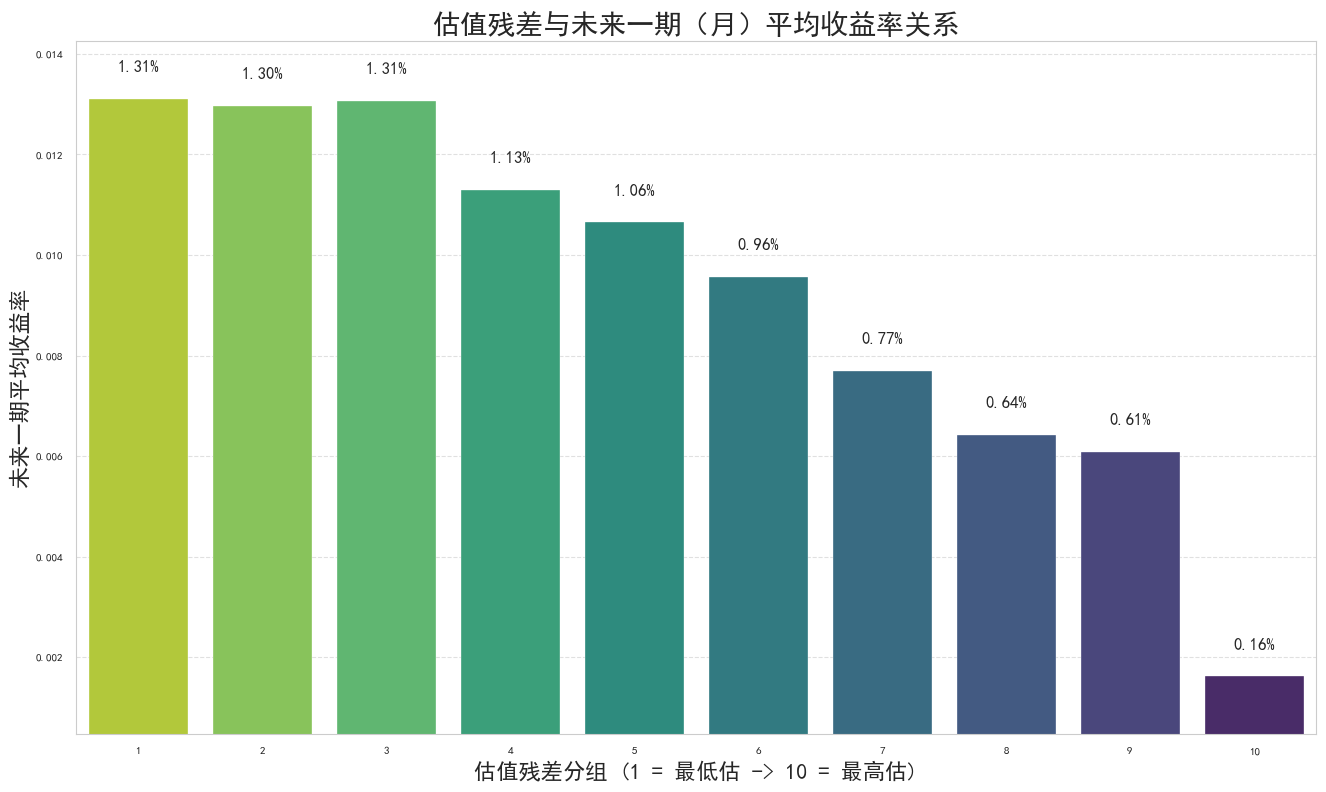

In [21]:
# 分析：残差分布
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# =================================================================== #
#                           【1. 配置区域】                           #
# =================================================================== #

# --- 文件路径配置 ---
# 【请修改】确保以下文件路径正确
DATA_PATH = Path("E:/PBROE/data")
CH3_PATH = Path("E:/PBROE/ch3")

# 包含残差数据的文件 (由 pbroe3.1 脚本生成)
RESIDUAL_FILE = CH3_PATH / 'pbroe3.1.csv'
# 包含月度收益率数据的文件
RETURNS_FILE = DATA_PATH / 'TRDNEW_Mnth.csv'

# --- 输出配置 ---
output_dir = Path("./ch3_pics")
output_dir.mkdir(exist_ok=True)

# =================================================================== #
#                           【2. 绘图风格设置】                       #
# =================================================================== #

def set_academic_style():
    """设置图表的学术风格"""
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    plt.style.use('seaborn-v0_8-paper')
    plt.rcParams['font.size'] = 18

set_academic_style()

# =================================================================== #
#                       【3. 数据加载与合并】                         #
# =================================================================== #
print("--- 步骤 1: 加载残差数据和收益率数据 ---")

try:
    # 加载残差数据
    df_residual = pd.read_csv(RESIDUAL_FILE)
    df_residual['调入日期'] = pd.to_datetime(df_residual['调入日期'])
    # 【已修复】统一 stkcd 的数据类型为补零的字符串
    df_residual['stkcd'] = df_residual['stkcd'].astype(str).str.zfill(6)
    print(f"成功加载 {len(df_residual)} 条残差数据。")

    # 加载收益率数据
    df_returns = pd.read_csv(RETURNS_FILE, usecols=['Stkcd', 'Trdmnt', 'Mretwd'])
    df_returns.rename(columns={'Stkcd': 'stkcd', 'Trdmnt': 'return_month', 'Mretwd': 'next_month_return'}, inplace=True)
    df_returns['stkcd'] = df_returns['stkcd'].astype(str).str.zfill(6)
    df_returns['return_month'] = pd.to_datetime(df_returns['return_month'])
    df_returns['next_month_return'] = pd.to_numeric(df_returns['next_month_return'], errors='coerce')
    print(f"成功加载 {len(df_returns)} 条收益率数据。")

except FileNotFoundError as e:
    print(f"错误: 无法找到文件 {e.filename}。请检查文件路径配置。")
    # 如果文件不存在，则退出
    exit()

print("\n--- 步骤 2: 合并数据，将 T 期的残差与 T+1 期的收益率对齐 ---")

# 在残差表中，'调入日期' 是 T+1 月的月初，我们需要用它来匹配 T+1 月的收益
# 我们将 '调入日期' 转换为 'YYYY-MM' 格式作为匹配键
df_residual['merge_key'] = df_residual['调入日期'].dt.strftime('%Y-%m')
df_returns['merge_key'] = df_returns['return_month'].dt.strftime('%Y-%m')

# 合并数据
df_analysis = pd.merge(
    df_residual,
    df_returns[['stkcd', 'merge_key', 'next_month_return']],
    on=['stkcd', 'merge_key'],
    how='left'
)

# 清除没有匹配到下期收益的数据
df_analysis.dropna(subset=['next_month_return'], inplace=True)

print(f"数据合并完成，共得到 {len(df_analysis)} 条有效的分析样本。")


# =================================================================== #
#                       【4. 残差分布直方图】                         #
# =================================================================== #
print("\n--- 步骤 3: 绘制残差分布直方图 ---")

plt.figure(figsize=(12, 7))
sns.histplot(df_analysis['residual_zscore'], bins=100, kde=True, color='#5D69B1')
plt.title('估值残差因子 (Z-Score) 分布', fontsize=20)
plt.xlabel('标准化残差 (Z-Score)', fontsize=16)
plt.ylabel('频数', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(-4, 4) # 限制x轴范围，更好地观察核心分布

save_path = output_dir / 'residual_distribution_histogram.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"残差分布图已保存至: {save_path}")
plt.show()


# =================================================================== #
#                  【5. 残差分组与收益率关系图】                      #
# =================================================================== #
print("\n--- 步骤 4: 绘制残差分组与收益率关系图 ---")

# 对所有样本，按残差大小分为10组 (十分位)
df_analysis['residual_group'] = pd.qcut(df_analysis['residual_zscore'], 10, labels=False) + 1

# --- 图一：箱线图 (展示分布) ---
plt.figure(figsize=(16, 9))
sns.boxplot(x='residual_group', y='next_month_return', data=df_analysis, palette='viridis', showfliers=False)

# 计算并绘制每组的中位数连线
group_medians = df_analysis.groupby('residual_group')['next_month_return'].median()
plt.plot(group_medians.index - 1, group_medians.values, 'r-o', lw=2, label='收益率中位数')

plt.title('估值残差与未来一期收益率关系 (箱线图)', fontsize=20)
plt.xlabel('估值残差分组 (1 = 最低估 -> 10 = 最高估)', fontsize=16)
plt.ylabel('未来一期收益率', fontsize=16)
plt.axhline(0, color='grey', linestyle='--', lw=1.5)

plt.legend(fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)

save_path_box = output_dir / 'residual_return_boxplot.png'
plt.savefig(save_path_box, dpi=300, bbox_inches='tight')
print(f"残差-收益率关系(箱线图)已保存至: {save_path_box}")
plt.show()


# --- 【新增】图二：柱状图 (展示均值) ---
print("\n--- 步骤 5: 绘制残差分组与平均收益率关系柱状图 ---")

# 计算每组的平均收益率
group_means = df_analysis.groupby('residual_group')['next_month_return'].mean()

plt.figure(figsize=(16, 9))
bar_plot = sns.barplot(x=group_means.index, y=group_means.values, palette='viridis_r') # 使用反色系

# 添加数据标签
for index, value in enumerate(group_means):
    plt.text(index, value + 0.0005 * np.sign(value), f'{value:.2%}',
             ha='center', va='bottom' if value >= 0 else 'top', fontsize=12)

plt.title('估值残差与未来一期（月）平均收益率关系', fontsize=20)
plt.xlabel('估值残差分组 (1 = 最低估 -> 10 = 最高估)', fontsize=16)
plt.ylabel('未来一期平均收益率', fontsize=16)
plt.axhline(0, color='grey', linestyle='--', lw=1.5)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# 调整y轴范围以更好地显示标签
min_y, max_y = group_means.min(), group_means.max()
padding = (max_y - min_y) * 0.1
plt.ylim(min_y - padding, max_y + padding)

save_path_bar = output_dir / 'residual_return_barplot.png'
plt.savefig(save_path_bar, dpi=300, bbox_inches='tight')
print(f"残差-平均收益率关系(柱状图)已保存至: {save_path_bar}")
plt.show()


In [34]:
  # 回测：pbroe3.1 (回归残差策略)
import pandas as pd
import numpy as np
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')

# =================================================================== #
#                           【1. 配置区域】                           #
# =================================================================== #

# --- 文件路径配置 ---
# 【请修改】确保以下文件路径正确
DATA_PATH = Path("E:/PBROE/data")
CH3_PATH = Path("E:/PBROE/ch3")

# 包含所有股票残差数据的文件
RESIDUAL_FILE = CH3_PATH / 'pbroe3.1.csv'
# 收益率和基准文件
RETURNS_FILE = DATA_PATH / 'TRDNEW_Mnth.csv'
BENCHMARK_FILE = DATA_PATH / 'benchmark_indices.csv'

# --- 策略参数配置 ---
# 选择残差最低的百分比作为持仓
RESIDUAL_QUANTILE = 0.1 # 选择残差最低的10%

# --- 回测参数配置 ---
BACKTEST_START_DATE = '2010-05-01' # 回测起始日期 (YYYY-MM-DD)
BACKTEST_END_DATE = '2025-04-30'   # 回测结束日期 (YYYY-MM-DD)
BENCHMARK_CODE = '000300'          # 业绩基准代码，沪深300
BENCHMARK_NAME = '沪深300'         # 基准名称，用于报告
RISK_FREE_RATE = 0.03              # 无风险利率，用于计算夏普比率

# =================================================================== #
#                  【2. 投资组合构建模块】                          #
# =================================================================== #

def build_portfolio_from_residuals(residual_file_path, quantile):
    """
    从残差数据文件中，根据指定的分位数阈值构建投资组合。
    """
    print("--- 步骤 1: 从残差数据构建投资组合 ---")
    try:
        df_all = pd.read_csv(residual_file_path)
        df_all['调入日期'] = pd.to_datetime(df_all['调入日期'])
        # 【已修复】统一 stkcd 的数据类型为补零的字符串
        df_all['stkcd'] = df_all['stkcd'].astype(str).str.zfill(6)
        print(f"成功加载 {len(df_all)} 条残差数据。")
    except FileNotFoundError:
        print(f"错误: 找不到残差文件 {residual_file_path}。")
        return None

    # 按每个调入日期分组，筛选出残差最低的股票
    portfolio_list = []
    for date, group in df_all.groupby('调入日期'):
        threshold = group['residual_zscore'].quantile(quantile)
        selected_stocks = group[group['residual_zscore'] <= threshold]
        portfolio_list.append(selected_stocks)

    strategy_df = pd.concat(portfolio_list)
    print(f"已根据残差最低 {quantile*100:.0f}% 的标准，构建了包含 {len(strategy_df)} 条持仓记录的投资组合。\n")
    return strategy_df


# =================================================================== #
#                  【3. 数据加载与预处理模块】                      #
# =================================================================== #

def load_and_preprocess_data(returns_path, benchmark_path, benchmark_code):
    """
    加载并预处理收益率和基准数据。
    """
    print("--- 步骤 2: 加载并预处理收益与基准数据 ---")
    try:
        try:
            returns_df = pd.read_csv(returns_path)
        except UnicodeDecodeError:
            returns_df = pd.read_csv(returns_path, encoding='gbk')
        all_benchmarks_df = pd.read_csv(benchmark_path)
        print("收益与基准数据文件加载成功。")

    except FileNotFoundError as e:
        print(f"错误: 无法找到数据文件 {e.filename}。")
        return None, None

    # --- 预处理股票收益文件 ---
    returns_df['Stkcd'] = returns_df['Stkcd'].astype(str).str.zfill(6)
    returns_df['Trdmnt'] = pd.to_datetime(returns_df['Trdmnt'])
    returns_df['Mretwd'] = pd.to_numeric(returns_df['Mretwd'], errors='coerce')
    returns_df['merge_key'] = returns_df['Trdmnt'].dt.strftime('%Y-%m')

    # --- 预处理基准文件 ---
    all_benchmarks_df['Indexcd'] = all_benchmarks_df['Indexcd'].astype(str).str.zfill(6)
    benchmark_df = all_benchmarks_df[all_benchmarks_df['Indexcd'] == benchmark_code].copy()
    if benchmark_df.empty:
        print(f"错误: 在基准文件中未能找到代码为 '{benchmark_code}' 的数据。")
        return None, None
    benchmark_df['date'] = pd.to_datetime(benchmark_df['Month'], format='%Y-%m')
    benchmark_df['merge_key'] = benchmark_df['date'].dt.strftime('%Y-%m')
    benchmark_df.rename(columns={'Idxrtn': 'benchmark_return'}, inplace=True)
    benchmark_df = benchmark_df[['merge_key', 'benchmark_return']]

    print("数据预处理完成。\n")
    return returns_df, benchmark_df

# =================================================================== #
#                       【4. 核心回测逻辑模块】                       #
# =================================================================== #

def run_backtest(strategy_df, returns_df, start_date_str, end_date_str):
    """
    执行回测循环，计算投资组合的月度收益率。
    """
    print("--- 步骤 3: 执行回测 ---")
    strategy_df.rename(columns={'调入日期': 'rebalance_date'}, inplace=True)
    start_date = pd.to_datetime(start_date_str)
    end_date = pd.to_datetime(end_date_str)
    strategy_df = strategy_df[(strategy_df['rebalance_date'] >= start_date) & (strategy_df['rebalance_date'] <= end_date)]
    if strategy_df.empty:
        print("错误：在指定的回测期间内，没有找到任何有效的调仓数据。")
        return pd.DataFrame()
    rebalance_dates = sorted(strategy_df['rebalance_date'].unique())
    print(f"回测期间内的调仓日期数量: {len(rebalance_dates)}")
    monthly_returns_list = []

    for rebalance_date in rebalance_dates:
        current_portfolio = strategy_df[strategy_df['rebalance_date'] == rebalance_date]['stkcd'].tolist()
        month_key = rebalance_date.strftime('%Y-%m')
        month_returns_data = returns_df[
            (returns_df['merge_key'] == month_key) &
            (returns_df['Stkcd'].isin(current_portfolio))
        ]
        valid_returns = month_returns_data.dropna(subset=['Mretwd'])
        if not valid_returns.empty:
            portfolio_return = valid_returns['Mretwd'].mean()
            return_date = valid_returns['Trdmnt'].iloc[0]
            monthly_returns_list.append({
                'date': return_date,
                'portfolio_return': portfolio_return,
            })

    if not monthly_returns_list:
        print("错误：在指定的回测期间内，未能计算出任何月度收益率。")
        return pd.DataFrame()

    portfolio_returns_df = pd.DataFrame(monthly_returns_list).sort_values('date').reset_index(drop=True)
    print(f"回测循环完成，已生成 {len(portfolio_returns_df)} 条月度收益记录。\n")
    return portfolio_returns_df

# =================================================================== #
#                       【5. 年化换手率计算模块】                     #
# =================================================================== #

def calculate_annual_turnover(strategy_df, start_date_str, end_date_str):
    print("--- 步骤 4: 计算年化换手率 ---")
    # 【已修复】在函数内部统一列名，以避免KeyError
    strategy_df.rename(columns={'调入日期': 'rebalance_date'}, inplace=True)

    start_date = pd.to_datetime(start_date_str)
    end_date = pd.to_datetime(end_date_str)
    strategy_df = strategy_df[(strategy_df['rebalance_date'] >= start_date) & (strategy_df['rebalance_date'] <= end_date)]
    rebalance_dates = sorted(strategy_df['rebalance_date'].unique())
    if len(rebalance_dates) < 2: return 0.0
    turnover_list = []
    for i in range(1, len(rebalance_dates)):
        prev_date, curr_date = rebalance_dates[i-1], rebalance_dates[i]
        prev_portfolio = set(strategy_df[strategy_df['rebalance_date'] == prev_date]['stkcd'])
        curr_portfolio = set(strategy_df[strategy_df['rebalance_date'] == curr_date]['stkcd'])
        if not prev_portfolio: continue
        stocks_sold = len(prev_portfolio - curr_portfolio)
        period_turnover = stocks_sold / len(prev_portfolio)
        turnover_list.append(period_turnover)
    if not turnover_list: return 0.0
    avg_period_turnover = np.mean(turnover_list)
    total_years = (rebalance_dates[-1] - rebalance_dates[0]).days / 365.25
    rebalances_per_year = len(turnover_list) / total_years if total_years > 0 else 0
    annual_turnover = avg_period_turnover * rebalances_per_year
    print(f"计算完成。预估年化换手率: {annual_turnover:.2%}\n")
    return annual_turnover

# =================================================================== #
#                       【6. 绩效计算与保存模块】                     #
# =================================================================== #

def calculate_performance_and_save(portfolio_returns_df, benchmark_df, annual_turnover, benchmark_name):
    print("--- 步骤 5: 计算绩效并保存结果 ---")
    # ... (此处省略与之前版本完全相同的绩效计算代码)
    portfolio_returns_df['merge_key'] = portfolio_returns_df['date'].dt.strftime('%Y-%m')
    merged_df = pd.merge(portfolio_returns_df, benchmark_df, on='merge_key', how='left')
    merged_df['benchmark_return'].fillna(0.0, inplace=True)
    merged_df.drop(columns=['merge_key'], inplace=True)
    total_months = len(merged_df)
    if total_months == 0: return None, None
    merged_df['cumulative_return'] = (1 + merged_df['portfolio_return']).cumprod()
    final_cumulative_return = merged_df['cumulative_return'].iloc[-1]
    annualized_return = final_cumulative_return ** (12 / total_months) - 1
    annualized_volatility = merged_df['portfolio_return'].std() * np.sqrt(12)
    sharpe_ratio = (annualized_return - RISK_FREE_RATE) / annualized_volatility if annualized_volatility != 0 else 0
    rolling_max = merged_df['cumulative_return'].expanding().max()
    drawdown = (merged_df['cumulative_return'] - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    annualized_benchmark_return = (1 + merged_df['benchmark_return']).prod() ** (12 / total_months) - 1
    excess_return = merged_df['portfolio_return'] - merged_df['benchmark_return']
    annualized_excess_return = annualized_return - annualized_benchmark_return
    tracking_error = excess_return.std() * np.sqrt(12)
    information_ratio = annualized_excess_return / tracking_error if tracking_error != 0 else 0
    metrics = {'年化收益率': annualized_return, '年化波动率': annualized_volatility, '夏普比率': sharpe_ratio, '最大回撤': max_drawdown, '年化换手率': annual_turnover, '年化超额收益率': annualized_excess_return, '信息比率': information_ratio, '跟踪误差': tracking_error, '基准年化收益率': annualized_benchmark_return, '累计收益率': final_cumulative_return - 1}
    print("\n--- PB-ROE 策略 (pbroe3.1 - 回归残差模型) 绩效简报 ---")
    for key, value in metrics.items():
        print(f"{key+':':<12} {value:.2%}" if isinstance(value, float) and ('率' in key or '回撤' in key) else f"{key+':':<12} {value:.4f}")
    returns_filename = 'pbroe3.1_returns.csv'
    metrics_filename = 'pbroe3.1_performance.csv'
    merged_df.to_csv(returns_filename, index=False, encoding='utf-8-sig', float_format='%.6f')
    print(f"\n月度收益率详情已保存至: {returns_filename}")
    pd.DataFrame([metrics]).to_csv(metrics_filename, index=False, encoding='utf-8-sig', float_format='%.6f')
    print(f"绩效指标已保存至: {metrics_filename}\n")
    return merged_df, metrics

# =================================================================== #
#                          【7. 主函数执行】                          #
# =================================================================== #

def main():
    """
    主执行函数
    """
    try:
        # 1. 构建投资组合
        strategy_df = build_portfolio_from_residuals(RESIDUAL_FILE, RESIDUAL_QUANTILE)
        if strategy_df is None: return

        # 2. 加载回测所需数据
        returns_df, benchmark_df = load_and_preprocess_data(
            RETURNS_FILE, BENCHMARK_FILE, BENCHMARK_CODE
        )
        if returns_df is None: return

        # 3. 执行回测
        portfolio_returns_df = run_backtest(
            strategy_df.copy(), returns_df, BACKTEST_START_DATE, BACKTEST_END_DATE
        )
        if portfolio_returns_df.empty: return

        # 4. 计算换手率
        annual_turnover = calculate_annual_turnover(
            strategy_df.copy(), BACKTEST_START_DATE, BACKTEST_END_DATE
        )

        # 5. 计算并保存最终绩效
        final_df, metrics = calculate_performance_and_save(
            portfolio_returns_df, benchmark_df, annual_turnover, BENCHMARK_NAME
        )
        print("\n回测完成！")

    except Exception as e:
        print(f"\n执行过程中出现严重错误: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()


--- 步骤 1: 从残差数据构建投资组合 ---
成功加载 499809 条残差数据。
已根据残差最低 10% 的标准，构建了包含 50046 条持仓记录的投资组合。

--- 步骤 2: 加载并预处理收益与基准数据 ---
收益与基准数据文件加载成功。
数据预处理完成。

--- 步骤 3: 执行回测 ---
回测期间内的调仓日期数量: 180
回测循环完成，已生成 180 条月度收益记录。

--- 步骤 4: 计算年化换手率 ---
计算完成。预估年化换手率: 193.12%

--- 步骤 5: 计算绩效并保存结果 ---

--- PB-ROE 策略 (pbroe3.1 - 回归残差模型) 绩效简报 ---
年化收益率:       14.53%
年化波动率:       25.00%
夏普比率:        46.14%
最大回撤:        -32.66%
年化换手率:       193.12%
年化超额收益率:     13.15%
信息比率:        91.29%
跟踪误差:        0.1440
基准年化收益率:     1.39%
累计收益率:       665.64%

月度收益率详情已保存至: pbroe3.1_returns.csv
绩效指标已保存至: pbroe3.1_performance.csv


回测完成！


In [27]:
# 回测：pbroe3.1all (残差分组策略)
import pandas as pd
import numpy as np
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')

# =================================================================== #
#                           【1. 配置区域】                           #
# =================================================================== #

# --- 文件路径配置 ---
# 【请修改】确保以下文件路径正确
DATA_PATH = Path("E:/PBROE/data")
CH3_PATH = Path("E:/PBROE/ch3")

# 包含所有股票残差数据的文件
RESIDUAL_FILE = CH3_PATH / 'pbroe3.1.csv'
# 收益率和基准文件
RETURNS_FILE = DATA_PATH / 'TRDNEW_Mnth.csv'
# 【已添加】基准文件路径
BENCHMARK_FILE = DATA_PATH / 'benchmark_indices.csv'

# --- 策略参数配置 ---
NUM_GROUPS = 10 # 要分的组数

# --- 回测参数配置 ---
BACKTEST_START_DATE = '2010-05-01' # 回测起始日期 (YYYY-MM-DD)
BACKTEST_END_DATE = '2025-04-30'   # 回测结束日期 (YYYY-MM-DD)
RISK_FREE_RATE = 0.03              # 无风险利率，用于计算夏普比率
# 【已添加】基准代码
BENCHMARK_CODE = '000300'

# --- 输出文件配置 ---
RETURNS_OUTPUT_FILE = 'pbroe3.1all_returns.csv'
PERFORMANCE_OUTPUT_FILE = 'pbroe3.1all_performance.csv'

# =================================================================== #
#                  【2. 投资组合构建模块】                          #
# =================================================================== #

def build_grouped_portfolios(residual_file_path, num_groups):
    """
    从残差数据文件中，将股票分为指定数量的组。
    """
    print(f"--- 步骤 1: 从残差数据构建 {num_groups} 个投资组合 ---")
    try:
        df_all = pd.read_csv(residual_file_path)
        df_all['调入日期'] = pd.to_datetime(df_all['调入日期'])
        df_all['stkcd'] = df_all['stkcd'].astype(str).str.zfill(6)
        print(f"成功加载 {len(df_all)} 条残差数据。")
    except FileNotFoundError:
        print(f"错误: 找不到残差文件 {residual_file_path}。")
        return None

    # 按每个调入日期分组，然后对组内股票按残差进行qcut分组
    df_all['residual_group'] = df_all.groupby('调入日期')['residual_zscore'].transform(
        lambda x: pd.qcut(x, num_groups, labels=False, duplicates='drop') + 1
    )

    # 清除无法成功分组的记录
    df_all.dropna(subset=['residual_group'], inplace=True)
    df_all['residual_group'] = df_all['residual_group'].astype(int)

    print(f"已根据残差将股票分为 {num_groups} 组。\n")
    return df_all


# =================================================================== #
#                       【3. 核心回测逻辑模块】                       #
# =================================================================== #

def run_grouped_backtest(strategy_df, returns_df, num_groups, start_date_str, end_date_str):
    """
    对所有分组并行执行回测。
    """
    print("--- 步骤 2: 对所有分组执行回测 ---")

    # --- 数据预处理 ---
    returns_df['Stkcd'] = returns_df['Stkcd'].astype(str).str.zfill(6)
    returns_df['Trdmnt'] = pd.to_datetime(returns_df['Trdmnt'])
    returns_df['Mretwd'] = pd.to_numeric(returns_df['Mretwd'], errors='coerce')
    returns_df['merge_key'] = returns_df['Trdmnt'].dt.strftime('%Y-%m')

    strategy_df.rename(columns={'调入日期': 'rebalance_date'}, inplace=True)
    start_date = pd.to_datetime(start_date_str)
    end_date = pd.to_datetime(end_date_str)
    strategy_df = strategy_df[(strategy_df['rebalance_date'] >= start_date) & (strategy_df['rebalance_date'] <= end_date)]
    rebalance_dates = sorted(strategy_df['rebalance_date'].unique())

    # --- 回测循环 ---
    all_returns_data = []
    for rebalance_date in rebalance_dates:
        month_key = rebalance_date.strftime('%Y-%m')
        monthly_returns = {'date': rebalance_date}

        # 对每个分组计算当月收益
        for group_id in range(1, num_groups + 1):
            current_portfolio = strategy_df[
                (strategy_df['rebalance_date'] == rebalance_date) &
                (strategy_df['residual_group'] == group_id)
            ]['stkcd'].tolist()

            if not current_portfolio:
                monthly_returns[f'portfolio_return_g{group_id}'] = 0.0
                continue

            month_returns_data = returns_df[
                (returns_df['merge_key'] == month_key) &
                (returns_df['Stkcd'].isin(current_portfolio))
            ]
            valid_returns = month_returns_data.dropna(subset=['Mretwd'])

            portfolio_return = valid_returns['Mretwd'].mean() if not valid_returns.empty else 0.0
            monthly_returns[f'portfolio_return_g{group_id}'] = portfolio_return

        all_returns_data.append(monthly_returns)

    if not all_returns_data:
        print("错误：未能计算出任何月度收益率。")
        return pd.DataFrame()

    portfolio_returns_df = pd.DataFrame(all_returns_data).sort_values('date').reset_index(drop=True)
    print(f"回测循环完成，已生成 {len(portfolio_returns_df)} 条月度收益记录。\n")
    return portfolio_returns_df

# =================================================================== #
#                       【4. 绩效计算与保存】                         #
# =================================================================== #

def calculate_and_save_performance(strategy_df, portfolio_returns_df, benchmark_df, num_groups):
    """
    为所有分组计算绩效并保存结果。
    """
    print("--- 步骤 3: 计算并保存所有分组的绩效 ---")

    all_metrics = []

    # --- 1. 将基准收益合并到总收益表 ---
    portfolio_returns_df['merge_key'] = portfolio_returns_df['date'].dt.strftime('%Y-%m')
    final_returns_df = pd.merge(portfolio_returns_df, benchmark_df, on='merge_key', how='left')
    final_returns_df['benchmark_return'].fillna(0.0, inplace=True)

    for group_id in range(1, num_groups + 1):
        # --- 2. 计算绩效指标 ---
        return_col = f'portfolio_return_g{group_id}'

        # 计算累计收益
        final_returns_df[f'cumulative_return_g{group_id}'] = (1 + final_returns_df[return_col]).cumprod()

        # 计算绩效
        total_months = len(final_returns_df)
        final_cumulative_return = final_returns_df[f'cumulative_return_g{group_id}'].iloc[-1]
        annualized_return = final_cumulative_return ** (12 / total_months) - 1
        annualized_volatility = final_returns_df[return_col].std() * np.sqrt(12)
        sharpe_ratio = (annualized_return - RISK_FREE_RATE) / annualized_volatility if annualized_volatility != 0 else 0
        rolling_max = final_returns_df[f'cumulative_return_g{group_id}'].expanding().max()
        drawdown = (final_returns_df[f'cumulative_return_g{group_id}'] - rolling_max) / rolling_max
        max_drawdown = drawdown.min()

        # 【已添加】计算与基准相关的指标
        annualized_benchmark_return = (1 + final_returns_df['benchmark_return']).prod() ** (12 / total_months) - 1
        excess_return = final_returns_df[return_col] - final_returns_df['benchmark_return']
        annualized_excess_return = annualized_return - annualized_benchmark_return
        tracking_error = excess_return.std() * np.sqrt(12)
        information_ratio = annualized_excess_return / tracking_error if tracking_error != 0 else 0

        # --- 3. 计算换手率 ---
        group_strategy_df = strategy_df[strategy_df['residual_group'] == group_id].copy()
        group_strategy_df.rename(columns={'调入日期': 'rebalance_date'}, inplace=True)
        rebalance_dates = sorted(group_strategy_df['rebalance_date'].unique())

        annual_turnover = 0.0
        if len(rebalance_dates) >= 2:
            turnover_list = []
            for i in range(1, len(rebalance_dates)):
                prev_date, curr_date = rebalance_dates[i-1], rebalance_dates[i]
                prev_portfolio = set(group_strategy_df[group_strategy_df['rebalance_date'] == prev_date]['stkcd'])
                curr_portfolio = set(group_strategy_df[group_strategy_df['rebalance_date'] == curr_date]['stkcd'])
                if not prev_portfolio: continue
                stocks_sold = len(prev_portfolio - curr_portfolio)
                period_turnover = stocks_sold / len(prev_portfolio)
                turnover_list.append(period_turnover)

            if turnover_list:
                avg_period_turnover = np.mean(turnover_list)
                total_years = (rebalance_dates[-1] - rebalance_dates[0]).days / 365.25
                rebalances_per_year = len(turnover_list) / total_years if total_years > 0 else 0
                annual_turnover = avg_period_turnover * rebalances_per_year

        metrics = {
            'group': group_id,
            '年化收益率': annualized_return,
            '年化波动率': annualized_volatility,
            '夏普比率': sharpe_ratio,
            '最大回撤': max_drawdown,
            '年化换手率': annual_turnover,
            '累计收益率': final_cumulative_return - 1,
            '年化超额收益率': annualized_excess_return,
            '信息比率': information_ratio,
            '跟踪误差': tracking_error,
            '基准年化收益率': annualized_benchmark_return,
        }
        all_metrics.append(metrics)

    # --- 4. 保存文件 ---
    performance_df = pd.DataFrame(all_metrics)

    # 整理最终收益文件列顺序
    cols_to_save = ['date', 'benchmark_return']
    for i in range(1, num_groups + 1):
        cols_to_save.append(f'portfolio_return_g{i}')
        cols_to_save.append(f'cumulative_return_g{i}')
    final_returns_df = final_returns_df[cols_to_save]

    final_returns_df.to_csv(RETURNS_OUTPUT_FILE, index=False, encoding='utf-8-sig', float_format='%.6f')
    print(f"\n所有分组的月度收益率详情已保存至: {RETURNS_OUTPUT_FILE}")

    performance_df.to_csv(PERFORMANCE_OUTPUT_FILE, index=False, encoding='utf-8-sig', float_format='%.6f')
    print(f"所有分组的绩效指标已保存至: {PERFORMANCE_OUTPUT_FILE}")

    print("\n--- 各分组绩效简报 ---")
    print(performance_df)


# =================================================================== #
#                          【5. 主函数执行】                          #
# =================================================================== #

def load_data(returns_path, benchmark_path, benchmark_code):
    """加载回测所需的所有数据"""
    try:
        returns_df = pd.read_csv(returns_path)
        all_benchmarks_df = pd.read_csv(benchmark_path)
    except FileNotFoundError as e:
        print(f"错误: 无法找到数据文件 {e.filename}。")
        return None, None

    all_benchmarks_df['Indexcd'] = all_benchmarks_df['Indexcd'].astype(str).str.zfill(6)
    benchmark_df = all_benchmarks_df[all_benchmarks_df['Indexcd'] == benchmark_code].copy()
    if benchmark_df.empty:
        print(f"错误: 在基准文件中未能找到代码为 '{benchmark_code}' 的数据。")
        return None, None
    benchmark_df['date'] = pd.to_datetime(benchmark_df['Month'], format='%Y-%m')
    benchmark_df['merge_key'] = benchmark_df['date'].dt.strftime('%Y-%m')
    benchmark_df.rename(columns={'Idxrtn': 'benchmark_return'}, inplace=True)
    benchmark_df = benchmark_df[['merge_key', 'benchmark_return']]

    return returns_df, benchmark_df

def main():
    """
    主执行函数
    """
    try:
        # 1. 构建分组投资组合
        strategy_df = build_grouped_portfolios(RESIDUAL_FILE, NUM_GROUPS)
        if strategy_df is None: return

        # 2. 加载回测所需收益和基准数据
        returns_df, benchmark_df = load_data(RETURNS_FILE, BENCHMARK_FILE, BENCHMARK_CODE)
        if returns_df is None: return

        # 3. 执行分组回测
        portfolio_returns_df = run_grouped_backtest(
            strategy_df.copy(), returns_df, NUM_GROUPS, BACKTEST_START_DATE, BACKTEST_END_DATE
        )
        if portfolio_returns_df.empty: return

        # 4. 计算并保存所有分组的绩效
        calculate_and_save_performance(
            strategy_df.copy(), portfolio_returns_df, benchmark_df, NUM_GROUPS
        )
        print("\n分组回测完成！")

    except Exception as e:
        print(f"\n执行过程中出现严重错误: {e}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()


--- 步骤 1: 从残差数据构建 10 个投资组合 ---
成功加载 499809 条残差数据。
已根据残差将股票分为 10 组。

--- 步骤 2: 对所有分组执行回测 ---
回测循环完成，已生成 180 条月度收益记录。

--- 步骤 3: 计算并保存所有分组的绩效 ---

所有分组的月度收益率详情已保存至: pbroe3.1all_returns.csv
所有分组的绩效指标已保存至: pbroe3.1all_performance.csv

--- 各分组绩效简报 ---
   group     年化收益率     年化波动率      夏普比率      最大回撤     年化换手率     累计收益率  \
0      1  0.145341  0.249997  0.461371 -0.326562  1.931225  6.656389   
1      2  0.139508  0.261646  0.418534 -0.368655  4.226305  6.091858   
2      3  0.127920  0.257507  0.380260 -0.359495  5.334754  5.083770   
3      4  0.108326  0.267199  0.293136 -0.428709  5.836698  3.677464   
4      5  0.101506  0.274122  0.260855 -0.488568  6.085975  3.263866   
5      6  0.082779  0.275821  0.191353 -0.506496  6.173835  2.296841   
6      7  0.062475  0.278206  0.116729 -0.553845  5.891822  1.481868   
7      8  0.048963  0.280486  0.067606 -0.591631  5.337146  1.048328   
8      9  0.049463  0.283344  0.068690 -0.627342  4.270146  1.063034   
9     10 -0.015004  0.284236 -0.1

--- 步骤 1: 加载分组回测收益数据 ---
成功加载 180 条月度收益记录。

--- 步骤 2: 绘制所有分组的累计收益曲线 ---
分组累计收益对比图已保存至: ch3_pics\decile_cumulative_returns_comparison.png


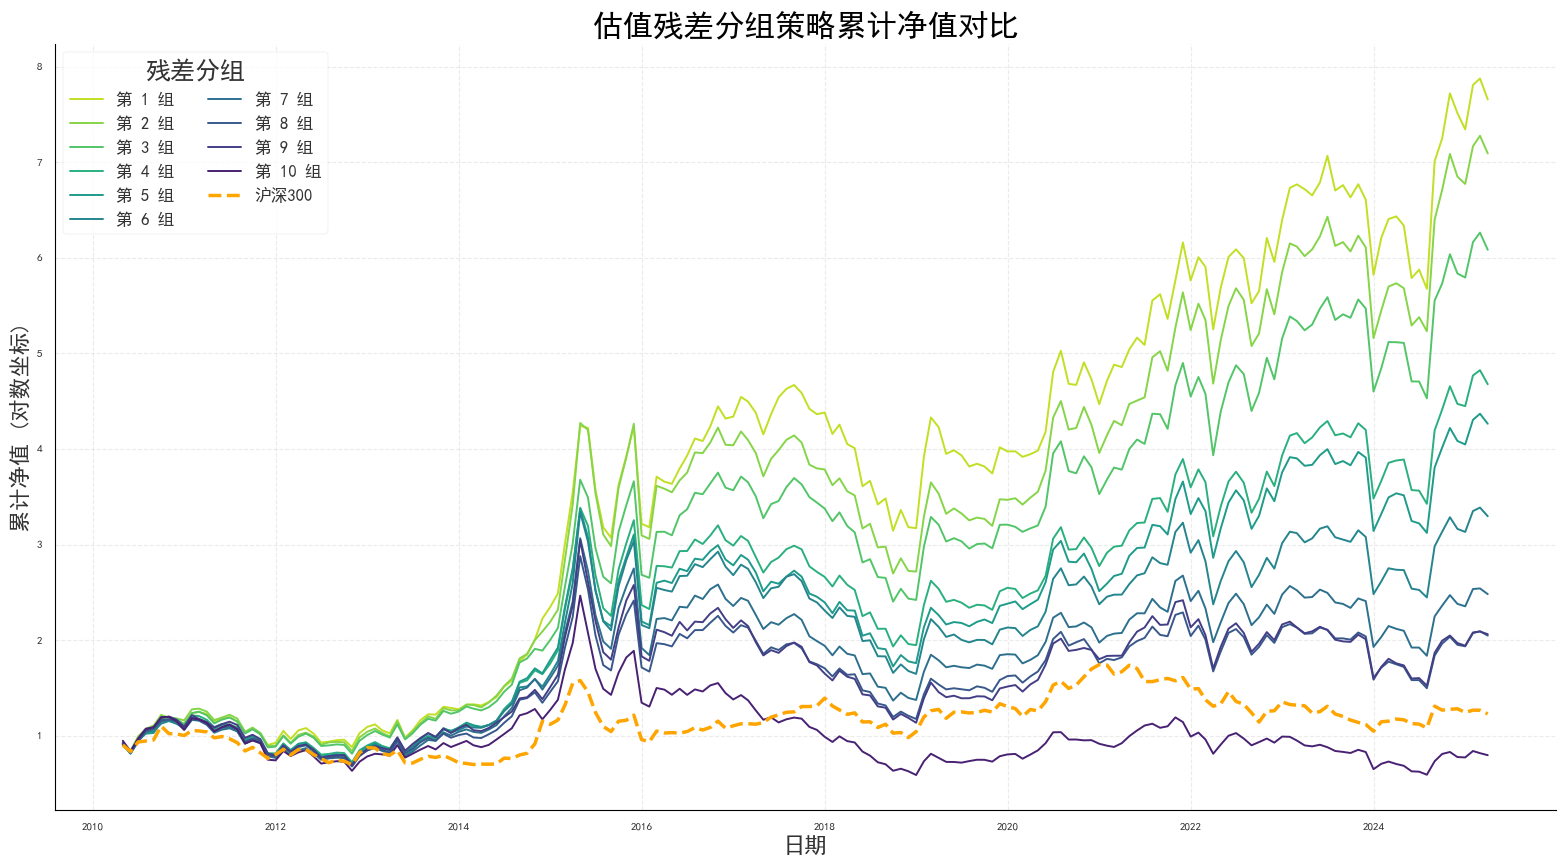

In [33]:
# 绘图：pbroe3.1 (残差分组累计收益对比)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from pathlib import Path

# =================================================================== #
#                           【1. 配置区域】                           #
# =================================================================== #

# --- 文件路径配置 ---
# 【请修改】确保以下文件路径正确
CH3_PATH = Path("E:/PBROE/ch3")

# 包含所有分组回测收益的文件
RETURNS_FILE = CH3_PATH / 'pbroe3.1all_returns.csv'

# --- 输出配置 ---
output_dir = Path("./ch3_pics")
output_dir.mkdir(exist_ok=True)

# =================================================================== #
#                           【2. 绘图风格设置】                       #
# =================================================================== #
set_academic_style()
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['font.size'] = 18


# =================================================================== #
#                       【3. 数据加载与绘图】                         #
# =================================================================== #
print("--- 步骤 1: 加载分组回测收益数据 ---")

try:
    df_returns = pd.read_csv(RETURNS_FILE)
    df_returns['date'] = pd.to_datetime(df_returns['date'])
    # 计算基准的累计净值
    df_returns['cumulative_benchmark'] = (1 + df_returns['benchmark_return']).cumprod()
    print(f"成功加载 {len(df_returns)} 条月度收益记录。")
except FileNotFoundError as e:
    print(f"错误: 无法找到文件 {e.filename}。请检查文件路径配置。")
    # 如果文件不存在，则退出
    exit()

print("\n--- 步骤 2: 绘制所有分组的累计收益曲线 ---")

plt.figure(figsize=(16, 9))

# --- 使用与箱线图/柱状图相同的 viridis 调色板 ---
# viridis_r 是反色，通常亮色代表数值小，深色代表数值大
colors = cm.get_cmap('viridis_r', 12) # 获取12种颜色，避免首尾颜色过于极端

# 绘制10个分组的累计收益曲线
for i in range(1, 11):
    group_col = f'cumulative_return_g{i}'
    plt.plot(df_returns['date'], df_returns[group_col], color=colors(i), label=f'第 {i} 组')

# 绘制基准曲线
plt.plot(df_returns['date'], df_returns['cumulative_benchmark'], color='orange', linestyle='--', linewidth=2.5, label='沪深300')

# --- 图表美化 ---
plt.title('估值残差分组策略累计净值对比', fontsize=22)
plt.xlabel('日期', fontsize=16)
plt.ylabel('累计净值 (对数坐标)', fontsize=16)
#plt.yscale('log') # 使用对数坐标轴，更好地展示长期增长趋势和差距
plt.legend(title='残差分组', fontsize=12, loc='upper left', ncol=2)
plt.grid(True, which="both", linestyle='--', alpha=0.5)
plt.tight_layout()

save_path = output_dir / 'decile_cumulative_returns_comparison.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"分组累计收益对比图已保存至: {save_path}")
plt.show()


--- 开始加载和合并数据 ---
成功加载估值残差模型策略文件: pbroe3.1_returns.csv
成功加载月度再平衡策略文件: pbroe2.3_returns.csv
数据加载和合并完成。

--- 正在绘制累计净值对比图 ---
累计净值对比图已保存至: ch3_pics\comparison_residual_vs_monthly_cumulative.png



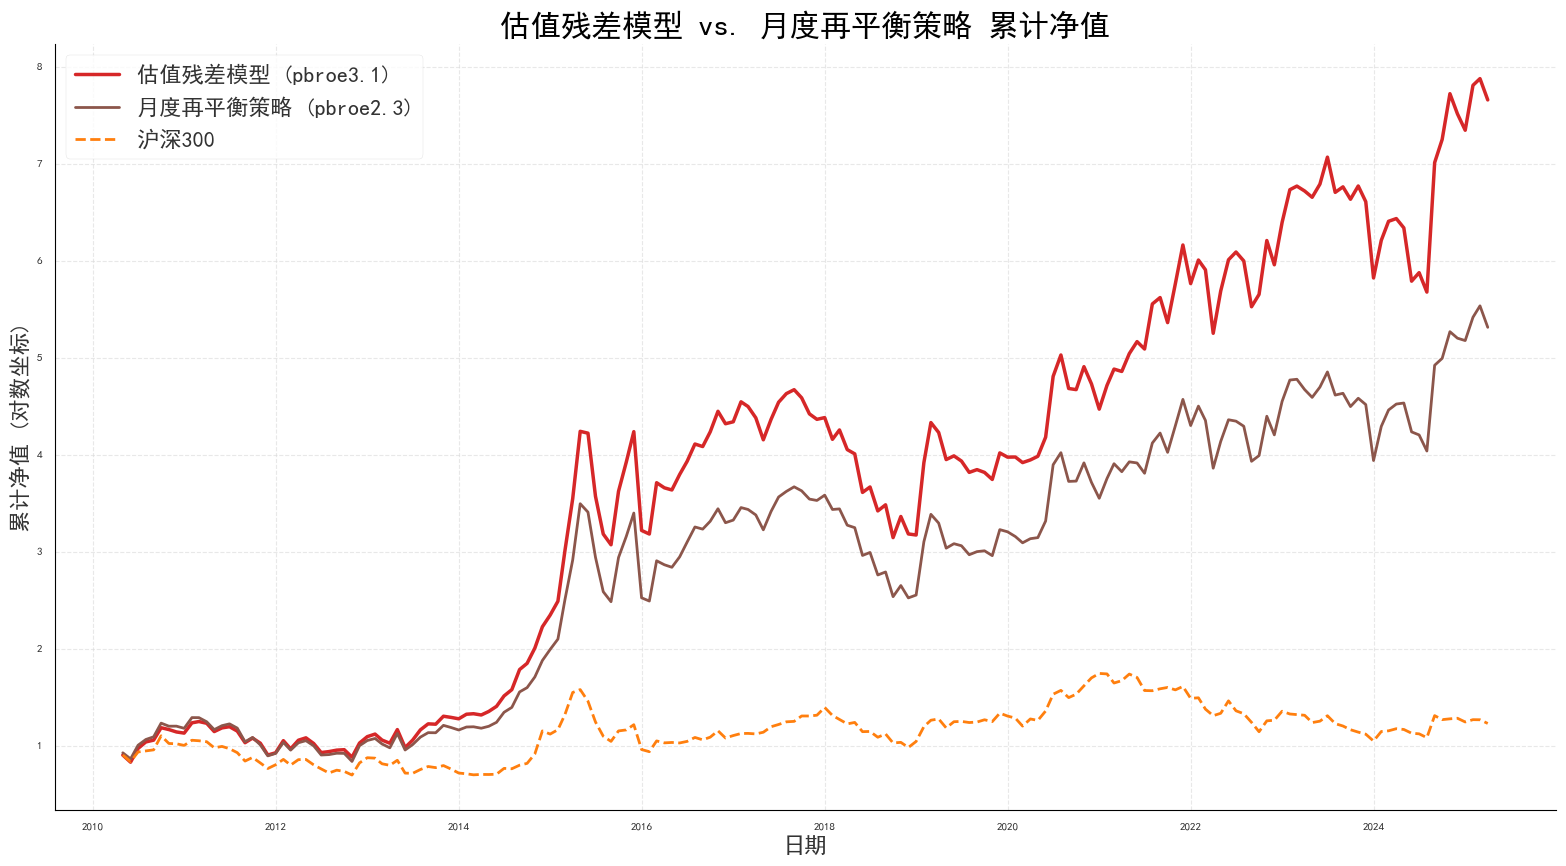

--- 正在绘制年度收益对比图 ---

--- 年度收益数据表 ---
      年份    估值残差模型   月度再平衡策略
0   2010  0.230863  0.246238
1   2011 -0.141730 -0.173393
2   2012 -0.029518 -0.050561
3   2013  0.284171  0.206636
4   2014  1.692823  1.468817
5   2015  0.031789 -0.016708
6   2016  0.197182  0.179191
7   2017 -0.074716 -0.031246
8   2018  0.043435  0.006596
9   2019 -0.066862 -0.048774
10  2020  0.231148  0.220354
11  2021  0.080968  0.009473
12  2022  0.279347  0.209848
13  2023 -0.042301 -0.031937
14  2024  0.190125  0.174926
年度收益对比图已保存至: ch3_pics\comparison_residual_vs_monthly_annual.png



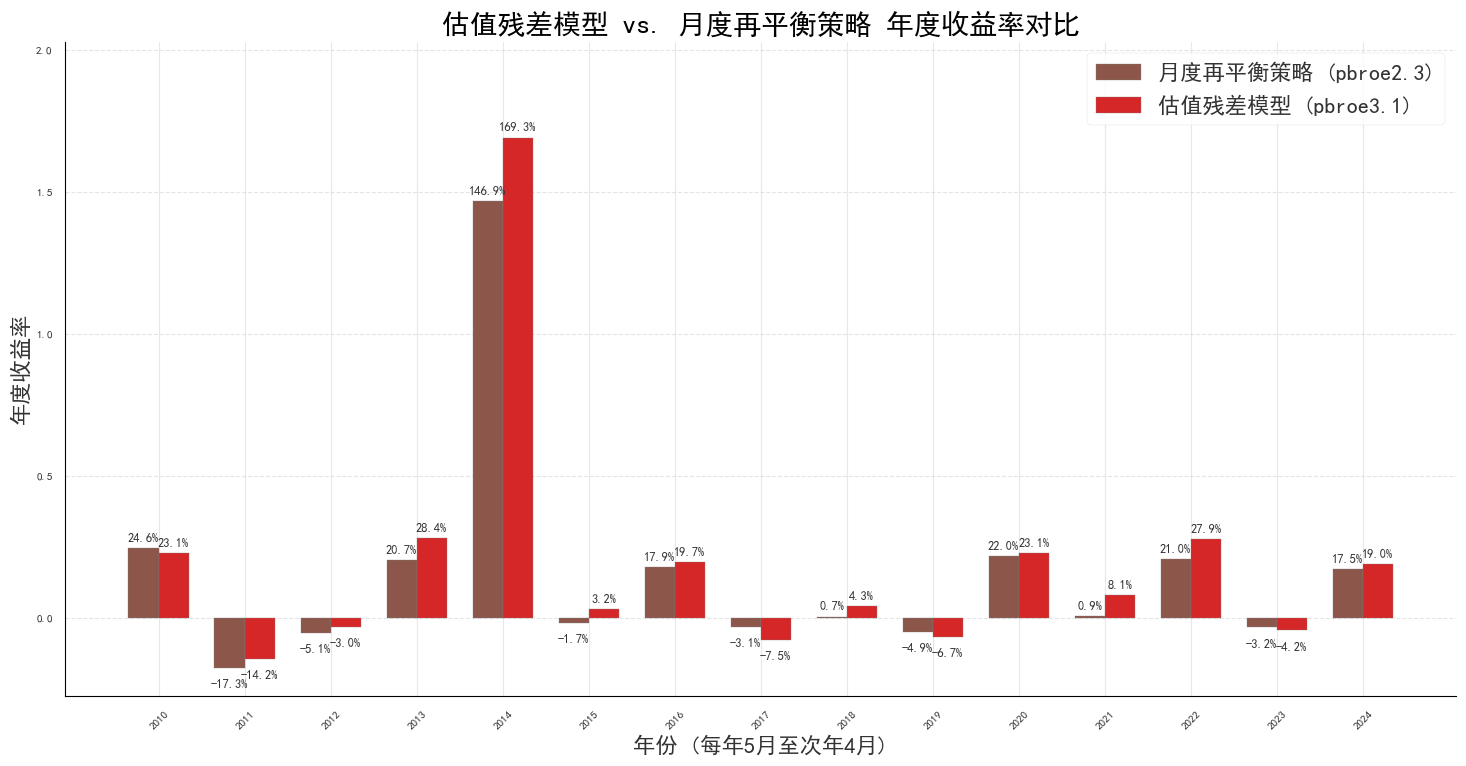

In [38]:
# 绘图：3.1 vs 2.3 双策略对比分析脚本
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# =================================================================== #
#                           【1. 配置区域】                           #
# =================================================================== #

# --- 文件路径配置 ---
# 【请修改】确保以下文件路径正确
CH2_PATH = Path("E:/PBROE/ch2")
CH3_PATH = Path("E:/PBROE/ch3")

# 估值残差模型策略 (pbroe3.1) 的回测结果文件
FILE_RESIDUAL = CH3_PATH / 'pbroe3.1_returns.csv'

# 月度再平衡策略 (pbroe2.3) 的回测结果文件
FILE_MONTHLY_REBALANCE = CH2_PATH / 'pbroe2.3_returns.csv'

# --- 输出配置 ---
output_dir = Path("./ch3_pics")
output_dir.mkdir(exist_ok=True)

# =================================================================== #
#                           【2. 绘图风格设置】                       #
# =================================================================== #
set_academic_style()
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['font.size'] = 18

def get_academic_colors(n, style='categorical'):
    """获取一个简单的颜色列表"""
    if style == 'categorical':
        # 蓝, 橙, 绿, 红, 紫, 棕
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
        return colors[:n]
    return None



# =================================================================== #
#                       【3. 数据加载与合并】                         #
# =================================================================== #

def load_and_merge_strategies(file_residual, file_monthly):
    """加载两个策略的收益文件并合并"""
    print("--- 开始加载和合并数据 ---")
    try:
        # 加载估值残差模型策略数据
        df_residual = pd.read_csv(file_residual)
        df_residual.rename(columns={
            'portfolio_return': 'return_residual',
            'benchmark_return': 'benchmark_return' # 基准收益从此文件获取
        }, inplace=True)
        print(f"成功加载估值残差模型策略文件: {file_residual.name}")

        # 加载月度再平衡策略数据
        df_monthly = pd.read_csv(file_monthly)
        df_monthly.rename(columns={
            'portfolio_return': 'return_monthly'
        }, inplace=True)
        print(f"成功加载月度再平衡策略文件: {file_monthly.name}")

    except FileNotFoundError as e:
        print(f"错误: 无法找到文件 {e.filename}。请检查文件路径配置。")
        return None

    # 统一日期格式
    df_residual['date'] = pd.to_datetime(df_residual['date'])
    df_monthly['date'] = pd.to_datetime(df_monthly['date'])

    # 使用外连接合并，确保所有日期都包含
    df_merged = pd.merge(
        df_residual[['date', 'return_residual', 'benchmark_return']],
        df_monthly[['date', 'return_monthly']],
        on='date',
        how='outer'
    ).sort_values('date').set_index('date')

    # 填充可能因合并产生的缺失值
    df_merged.fillna(0, inplace=True)

    print("数据加载和合并完成。\n")
    return df_merged

# 合并数据
df_compare = load_and_merge_strategies(FILE_RESIDUAL, FILE_MONTHLY_REBALANCE)

if df_compare is None:
    exit()

# =================================================================== #
#                     【4. 绘制累计净值对比图】                       #
# =================================================================== #

def plot_cumulative_returns(df):
    """绘制两个策略与基准的累计收益曲线"""
    print("--- 正在绘制累计净值对比图 ---")
    # 计算三个系列的累计净值
    df['cum_ret_residual'] = (1 + df['return_residual']).cumprod()
    df['cum_ret_monthly'] = (1 + df['return_monthly']).cumprod()
    df['cum_ret_benchmark'] = (1 + df['benchmark_return']).cumprod()

    colors = get_academic_colors(6)

    plt.figure(figsize=(16, 9))

    # 绘制曲线
    plt.plot(df.index, df['cum_ret_residual'], label='估值残差模型 (pbroe3.1)', color=colors[3], linewidth=2.5) # 红色
    plt.plot(df.index, df['cum_ret_monthly'], label='月度再平衡策略 (pbroe2.3)', color=colors[5], linewidth=2.0) # 棕色
    plt.plot(df.index, df['cum_ret_benchmark'], label='沪深300', color=colors[1], linestyle='--', linewidth=2) # 橙色虚线

    plt.title('估值残差模型 vs. 月度再平衡策略 累计净值', fontsize=22)
    plt.xlabel('日期', fontsize=16)
    plt.ylabel('累计净值 (对数坐标)', fontsize=16)
    plt.legend(fontsize=16)
    plt.grid(True, which="both", linestyle='--', alpha=0.6)
    plt.tight_layout()

    save_path = output_dir / 'comparison_residual_vs_monthly_cumulative.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"累计净值对比图已保存至: {save_path}\n")
    plt.show()

plot_cumulative_returns(df_compare)


# =================================================================== #
#                   【5. 绘制年度收益对比柱状图】                     #
# =================================================================== #

def plot_annual_returns(df):
    """绘制两个策略的年度收益对比柱状图"""
    print("--- 正在绘制年度收益对比图 ---")
    # 确定策略年度 (每年5月1日为新年度起点)
    df['策略年度'] = df.index.year - (df.index.month < 5)

    # 计算年度收益
    annual_returns = df.groupby('策略年度')[['return_residual', 'return_monthly']].apply(lambda x: (1 + x).prod() - 1).reset_index()
    annual_returns.rename(columns={
        'return_residual': '估值残差模型',
        'return_monthly': '月度再平衡策略',
        '策略年度': '年份'
    }, inplace=True)

    print("\n--- 年度收益数据表 ---")
    print(annual_returns)

    plt.figure(figsize=(15, 8))

    bar_width = 0.35
    r1 = np.arange(len(annual_returns['年份']))
    r2 = [x + bar_width for x in r1]

    colors = get_academic_colors(6)

    bars1 = plt.bar(r1, annual_returns['月度再平衡策略'], color=colors[5], width=bar_width, edgecolor='grey', label='月度再平衡策略 (pbroe2.3)')
    bars2 = plt.bar(r2, annual_returns['估值残差模型'], color=colors[3], width=bar_width, edgecolor='grey', label='估值残差模型 (pbroe3.1)')

    plt.title('估值残差模型 vs. 月度再平衡策略 年度收益率对比', fontsize=20)
    plt.xlabel('年份 (每年5月至次年4月)', fontsize=16)
    plt.ylabel('年度收益率', fontsize=16)
    plt.yscale('log')
    plt.xticks([r + bar_width/2 for r in range(len(annual_returns['年份']))], annual_returns['年份'], rotation=45)
    plt.legend(fontsize=16)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    def add_labels(bars):
        for bar in bars:
            height = bar.get_height()
            va = 'bottom' if height >= 0 else 'top'
            offset = 3 if height >= 0 else -8
            plt.annotate(f'{height:.1%}', xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, offset), textcoords="offset points", ha='center', va=va, fontsize=9)

    add_labels(bars1)
    add_labels(bars2)

    min_y = min(annual_returns['估值残差模型'].min(), annual_returns['月度再平衡策略'].min())
    max_y = max(annual_returns['估值残差模型'].max(), annual_returns['月度再平衡策略'].max())
    plt.ylim(min(min_y * 1.2, min_y - 0.1), max(max_y * 1.2, max_y + 0.1))
    plt.tight_layout()

    save_path = output_dir / 'comparison_residual_vs_monthly_annual.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"年度收益对比图已保存至: {save_path}\n")
    plt.show()

plot_annual_returns(df_compare)


--- 开始加载和合并数据 ---
成功加载估值残差模型策略文件: pbroe3.1_returns.csv
成功加载月度再平衡策略文件: pbroe2.3_returns.csv
数据加载和合并完成。

--- 正在绘制累计净值对比图 ---
累计净值对比图已保存至: ch3_pics\comparison_residual_vs_monthly_cumulative.png



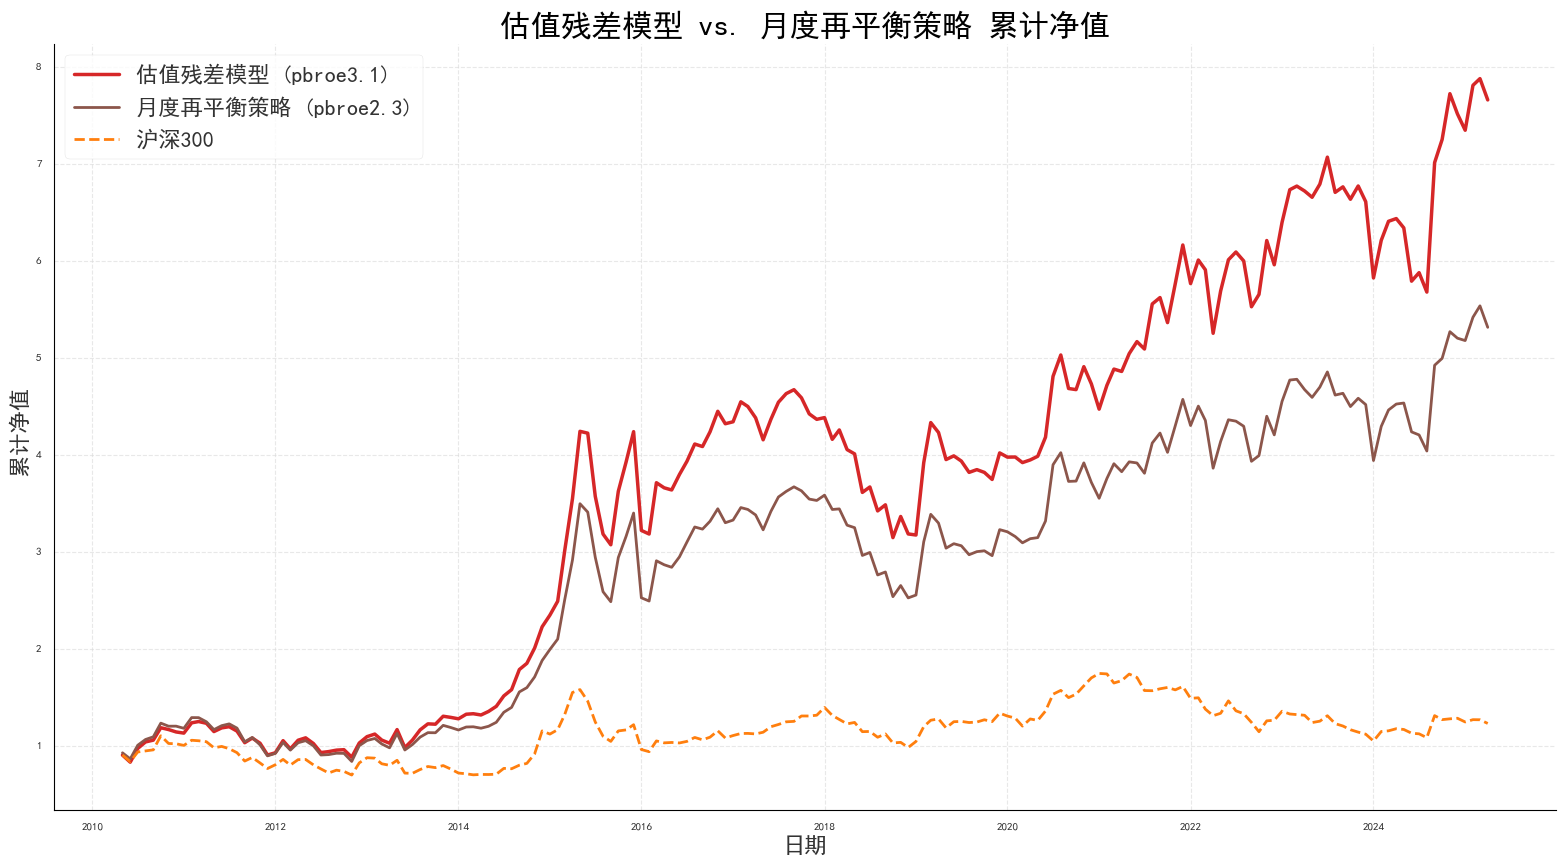

--- 正在绘制年度收益对比图 ---

--- 年度收益数据表 ---
      年份    估值残差模型   月度再平衡策略
0   2010  0.230863  0.246238
1   2011 -0.141730 -0.173393
2   2012 -0.029518 -0.050561
3   2013  0.284171  0.206636
4   2014  1.692823  1.468817
5   2015  0.031789 -0.016708
6   2016  0.197182  0.179191
7   2017 -0.074716 -0.031246
8   2018  0.043435  0.006596
9   2019 -0.066862 -0.048774
10  2020  0.231148  0.220354
11  2021  0.080968  0.009473
12  2022  0.279347  0.209848
13  2023 -0.042301 -0.031937
14  2024  0.190125  0.174926
年度收益对比图已保存至: ch3_pics\comparison_residual_vs_monthly_annual_broken_axis.png



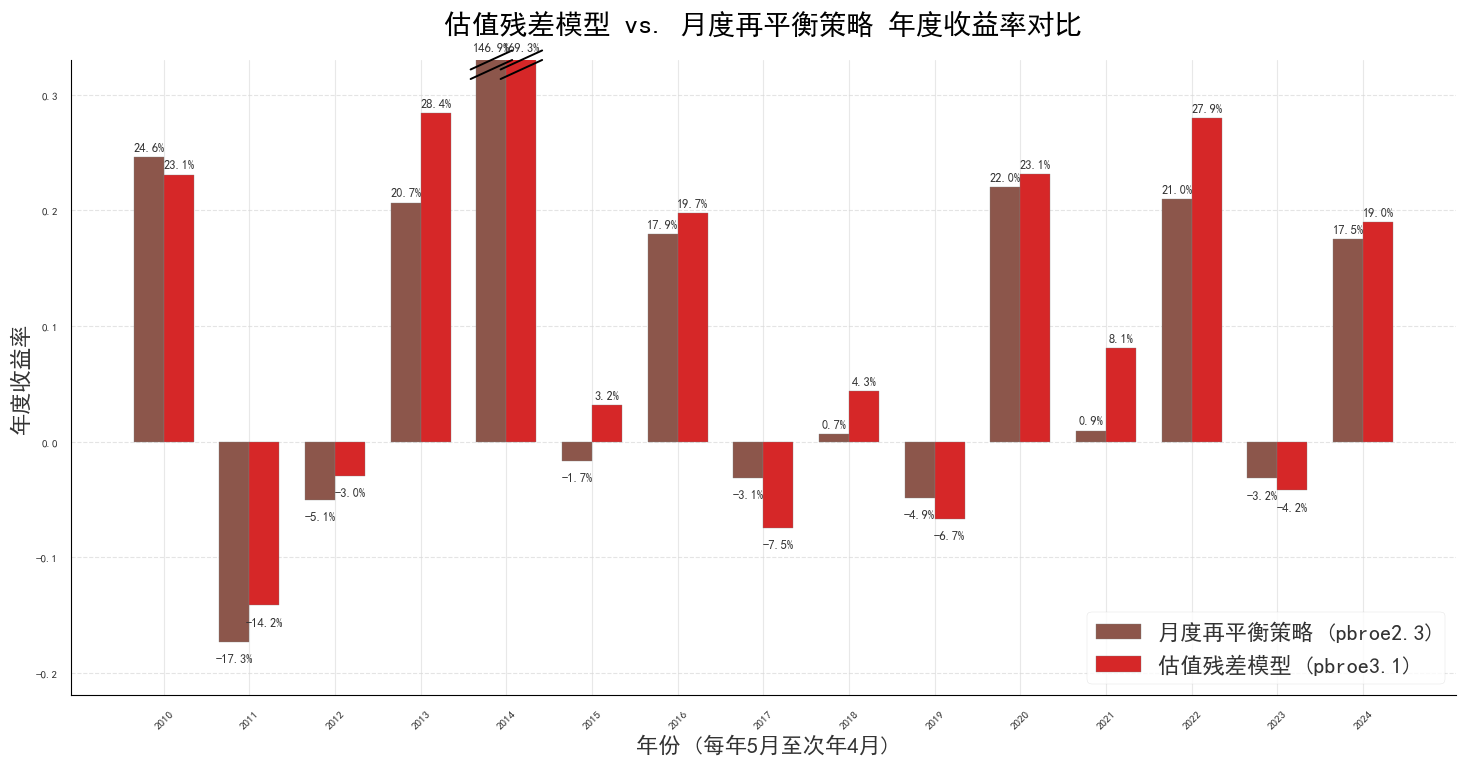

In [43]:
# 绘图：3.1 vs 2.3 双策略对比分析脚本
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# =================================================================== #
#                           【1. 配置区域】                           #
# =================================================================== #

# --- 文件路径配置 ---
# 【请修改】确保以下文件路径正确
CH2_PATH = Path("E:/PBROE/ch2")
CH3_PATH = Path("E:/PBROE/ch3")

# 估值残差模型策略 (pbroe3.1) 的回测结果文件
FILE_RESIDUAL = CH3_PATH / 'pbroe3.1_returns.csv'

# 月度再平衡策略 (pbroe2.3) 的回测结果文件
FILE_MONTHLY_REBALANCE = CH2_PATH / 'pbroe2.3_returns.csv'

# --- 输出配置 ---
output_dir = Path("./ch3_pics")
output_dir.mkdir(exist_ok=True)

# =================================================================== #
#                           【2. 绘图风格设置】                       #
# =================================================================== #
set_academic_style()
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.style.use('seaborn-v0_8-paper')
plt.rcParams['font.size'] = 18

def get_academic_colors(n, style='categorical'):
    """获取一个简单的颜色列表"""
    if style == 'categorical':
        # 蓝, 橙, 绿, 红, 紫, 棕
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
        return colors[:n]
    return None


# =================================================================== #
#                       【3. 数据加载与合并】                         #
# =================================================================== #

def load_and_merge_strategies(file_residual, file_monthly):
    """加载两个策略的收益文件并合并"""
    print("--- 开始加载和合并数据 ---")
    try:
        # 加载估值残差模型策略数据
        df_residual = pd.read_csv(file_residual)
        df_residual.rename(columns={
            'portfolio_return': 'return_residual',
            'benchmark_return': 'benchmark_return' # 基准收益从此文件获取
        }, inplace=True)
        print(f"成功加载估值残差模型策略文件: {file_residual.name}")

        # 加载月度再平衡策略数据
        df_monthly = pd.read_csv(file_monthly)
        df_monthly.rename(columns={
            'portfolio_return': 'return_monthly'
        }, inplace=True)
        print(f"成功加载月度再平衡策略文件: {file_monthly.name}")

    except FileNotFoundError as e:
        print(f"错误: 无法找到文件 {e.filename}。请检查文件路径配置。")
        return None

    # 统一日期格式
    df_residual['date'] = pd.to_datetime(df_residual['date'])
    df_monthly['date'] = pd.to_datetime(df_monthly['date'])

    # 使用外连接合并，确保所有日期都包含
    df_merged = pd.merge(
        df_residual[['date', 'return_residual', 'benchmark_return']],
        df_monthly[['date', 'return_monthly']],
        on='date',
        how='outer'
    ).sort_values('date').set_index('date')

    # 填充可能因合并产生的缺失值
    df_merged.fillna(0, inplace=True)

    print("数据加载和合并完成。\n")
    return df_merged

# 合并数据
df_compare = load_and_merge_strategies(FILE_RESIDUAL, FILE_MONTHLY_REBALANCE)

if df_compare is None:
    exit()

# =================================================================== #
#                     【4. 绘制累计净值对比图】                       #
# =================================================================== #

def plot_cumulative_returns(df):
    """绘制两个策略与基准的累计收益曲线"""
    print("--- 正在绘制累计净值对比图 ---")
    # 计算三个系列的累计净值
    df['cum_ret_residual'] = (1 + df['return_residual']).cumprod()
    df['cum_ret_monthly'] = (1 + df['return_monthly']).cumprod()
    df['cum_ret_benchmark'] = (1 + df['benchmark_return']).cumprod()

    colors = get_academic_colors(6)

    plt.figure(figsize=(16, 9))

    # 绘制曲线
    plt.plot(df.index, df['cum_ret_residual'], label='估值残差模型 (pbroe3.1)', color=colors[3], linewidth=2.5) # 红色
    plt.plot(df.index, df['cum_ret_monthly'], label='月度再平衡策略 (pbroe2.3)', color=colors[5], linewidth=2.0) # 棕色
    plt.plot(df.index, df['cum_ret_benchmark'], label='沪深300', color=colors[1], linestyle='--', linewidth=2) # 橙色虚线

    plt.title('估值残差模型 vs. 月度再平衡策略 累计净值', fontsize=22)
    plt.xlabel('日期', fontsize=16)
    plt.ylabel('累计净值 ', fontsize=16)
    plt.legend(fontsize=16)
    plt.grid(True, which="both", linestyle='--', alpha=0.6)
    plt.tight_layout()

    save_path = output_dir / 'comparison_residual_vs_monthly_cumulative.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"累计净值对比图已保存至: {save_path}\n")
    plt.show()

plot_cumulative_returns(df_compare)


# =================================================================== #
#                   【5. 绘制年度收益对比柱状图】                     #
# =================================================================== #

def plot_annual_returns(df):
    """绘制两个策略的年度收益对比柱状图"""
    print("--- 正在绘制年度收益对比图 ---")
    # 确定策略年度 (每年5月1日为新年度起点)
    df['策略年度'] = df.index.year - (df.index.month < 5)

    # 计算年度收益
    annual_returns = df.groupby('策略年度')[['return_residual', 'return_monthly']].apply(lambda x: (1 + x).prod() - 1).reset_index()
    annual_returns.rename(columns={
        'return_residual': '估值残差模型',
        'return_monthly': '月度再平衡策略',
        '策略年度': '年份'
    }, inplace=True)

    print("\n--- 年度收益数据表 ---")
    print(annual_returns)

    fig, ax = plt.subplots(figsize=(15, 8))

    bar_width = 0.35
    r1 = np.arange(len(annual_returns['年份']))
    r2 = [x + bar_width for x in r1]

    colors = get_academic_colors(6)

    bars1 = ax.bar(r1, annual_returns['月度再平衡策略'], color=colors[5], width=bar_width, edgecolor='grey', label='月度再平衡策略 (pbroe2.3)')
    bars2 = ax.bar(r2, annual_returns['估值残差模型'], color=colors[3], width=bar_width, edgecolor='grey', label='估值残差模型 (pbroe3.1)')

    # 【已修复】为标题添加 pad 参数，增加与图表的间距
    ax.set_title('估值残差模型 vs. 月度再平衡策略 年度收益率对比', fontsize=20, pad=20)
    ax.set_xlabel('年份 (每年5月至次年4月)', fontsize=16)
    ax.set_ylabel('年度收益率', fontsize=16)
    ax.set_xticks([r + bar_width/2 for r in range(len(annual_returns['年份']))])
    ax.set_xticklabels(annual_returns['年份'], rotation=45)
    ax.legend(fontsize=16)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # 截断Y轴以处理极端值
    other_years_returns = annual_returns[annual_returns['年份'] != 2014]
    min_y = other_years_returns[['估值残差模型', '月度再平衡策略']].min().min()
    max_y = other_years_returns[['估值残差模型', '月度再平衡策略']].max().max()

    y_limit_top = max_y + (max_y - min_y) * 0.1
    y_limit_bottom = min_y - (max_y - min_y) * 0.1
    ax.set_ylim(y_limit_bottom, y_limit_top)

    # 找到2014年的柱子并添加截断标记
    year_2014_index = annual_returns[annual_returns['年份'] == 2014].index[0]
    bar1_2014 = bars1[year_2014_index]
    bar2_2014 = bars2[year_2014_index]

    # 在被截断的柱子顶部绘制两条斜线
    d = .015
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    x1, _ = ax.transAxes.inverted().transform(ax.transData.transform((bar1_2014.get_x() + bar1_2014.get_width() / 2, 0)))
    x2, _ = ax.transAxes.inverted().transform(ax.transData.transform((bar2_2014.get_x() + bar2_2014.get_width() / 2, 0)))

    ax.plot((x1-d, x1+d), (1-d, 1+d), **kwargs)
    ax.plot((x1-d, x1+d), (1-2*d, 1), **kwargs)
    ax.plot((x2-d, x2+d), (1-d, 1+d), **kwargs)
    ax.plot((x2-d, x2+d), (1-2*d, 1), **kwargs)

    # 添加数据标签
    for bar in bars1 + bars2:
        height = bar.get_height()
        if height > y_limit_top:
            ax.annotate(f'{height:.1%}', xy=(bar.get_x() + bar.get_width() / 2, y_limit_top),
                         xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=9)
        else:
            va = 'bottom' if height >= 0 else 'top'
            offset = 3 if height >= 0 else -8
            ax.annotate(f'{height:.1%}', xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, offset), textcoords="offset points", ha='center', va=va, fontsize=9)

    plt.tight_layout()

    save_path = output_dir / 'comparison_residual_vs_monthly_annual_broken_axis.png'
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"年度收益对比图已保存至: {save_path}\n")
    plt.show()

plot_annual_returns(df_compare)
